In [2]:
from dataset_manager import MovieLensManager
from explainability_module import MovieLensExplainabilityModule
import numpy as np
import torch
from typing import List

In [3]:
df = MovieLensManager.load_dataset_from_hub("AhmadPython/MovieLens_KGE")
exp = MovieLensExplainabilityModule(df)

# Tutorial on how to customize the attention plots
If we want to customize the attention plots, we have to understand how the attentions are saved. Lets say we want to compare how the attentions on Natural Language parts of the prompt compare to the cls token, the embeddings and the seperator tokens, than we have to implement that mechanism.

In [4]:
(
    df["vanilla_attentions"].iloc[0].shape,
    df["prompt_attentions"].iloc[0].shape,
    df["attention_attentions"].iloc[0].shape,
)

((9, 9, 2), (13, 13, 2), (13, 13, 2))

The attentions are shaped after the positions we look at, for vanilla model that is 9 positions and for the the embedding models they are 13. The positions are:
[cls, user, sep1, movie, sep2, title, sep3, genres, sep4] + [user embedding, sep5, movie embedding, sep6]
The concecitive 9x9 (and 13x13) tuples describe how much attention one position the other has. And since there are 2 layers in the current Bert Model, there are 2 total from- to-positions.

In [6]:
exp.plot_attention_graph

<bound method ExplainabilityModule.plot_attention_graph of <explainability_module.MovieLensExplainabilityModule object at 0x00000197802791C0>>

There is the function *plot_attention_graph* that receives a tensor of attentions and a list of labels for the positions to plot the attention graph. We can use that function once we get the attention tensor in the correct shape.  Namely in the shape *[batch_size, length_of_positions, length_of_positions, 2]*, while *length_of_positions* is 3 for the vanilla model and 4 for the models that include KGEs. That results in the following function

In [7]:
def mean_over_positions(
    attentions: np.ndarray, all_positions: List[List[int]]
) -> np.ndarray:
    """
    We expect attentions of shape [batch_size, source positions, target positions, layers]
    While while source and target positions will be 9 for vanilla model and 13 for embedding models.
    """
    mean_attentions_over_target = np.zeros(  # we will fill this array in the first loop
        (
            attentions.shape[0],  # batch_size
            attentions.shape[1],  # source position
            len(
                all_positions
            ),  # target position (we reduce them to the amount of positions we want to compare)
            attentions.shape[-1],  # layers
        )
    )
    for idx, positions in enumerate(all_positions):
        mean_attentions_over_target[:, :, idx] = attentions[:, :, positions].mean(
            axis=2
        )  # for every position index list, we average over them and assign them to our result array

    mean_attentions_over_source = (  # the resulting is the average over the source positions.
        np.zeros(
            (
                attentions.shape[0],
                len(all_positions),
                len(all_positions),
                attentions.shape[-1],
            )
        )
    )
    for idx, positions in enumerate(all_positions):
        mean_attentions_over_source[:, idx] = mean_attentions_over_target[
            :, positions
        ].mean(axis=1)
    return mean_attentions_over_source

With this method, we have to assign the positions to each individual label and call the new function. As a result we should get one *[batch_size, 3, 3, 2]* array of vanilla attentions and two *[batch_size, 4, 4, 2]*. arrays of embedding attentions.

In [9]:
cls_position = [0]  # positions where cls is saved
nlp_positions = [1, 3, 5, 7]  # positions where all natural texts are saved
sep_positions = [2, 4, 6, 8]  # positions where all seperator torkens are saved
vanilla_positions = [cls_position, nlp_positions, sep_positions]
vanilla_attentions = np.array(df["vanilla_attentions"].tolist())
vanilla_attentions_nl_seperated = mean_over_positions(
    vanilla_attentions, vanilla_positions
)

sep_positions.extend(
    [10, 12]
)  # since there are embedding positions, there are also 2 more seperator positions.
embedding_positions = [9, 11]
embedding_positions = [cls_position, nlp_positions, embedding_positions, sep_positions]
prompt_attentions = np.array(df["prompt_attentions"].tolist())
prompt_attentions_nl_seperated = mean_over_positions(
    prompt_attentions, embedding_positions
)
attention_attentions = np.array(df["attention_attentions"].tolist())
attention_attentions_nl_seperated = mean_over_positions(
    attention_attentions, embedding_positions
)
(
    vanilla_attentions_nl_seperated.shape,
    prompt_attentions_nl_seperated.shape,
    attention_attentions_nl_seperated.shape,
)

((90753, 3, 3, 2), (90753, 4, 4, 2), (90753, 4, 4, 2))

Now whats only left to do is to call the plot function with the newly created attention arrays.

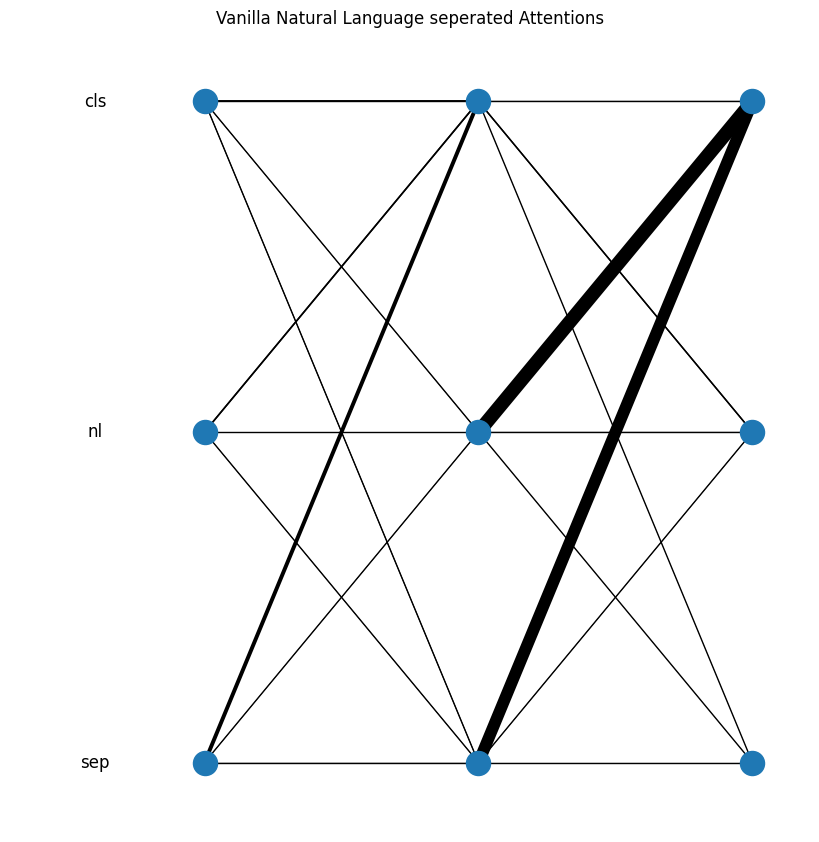

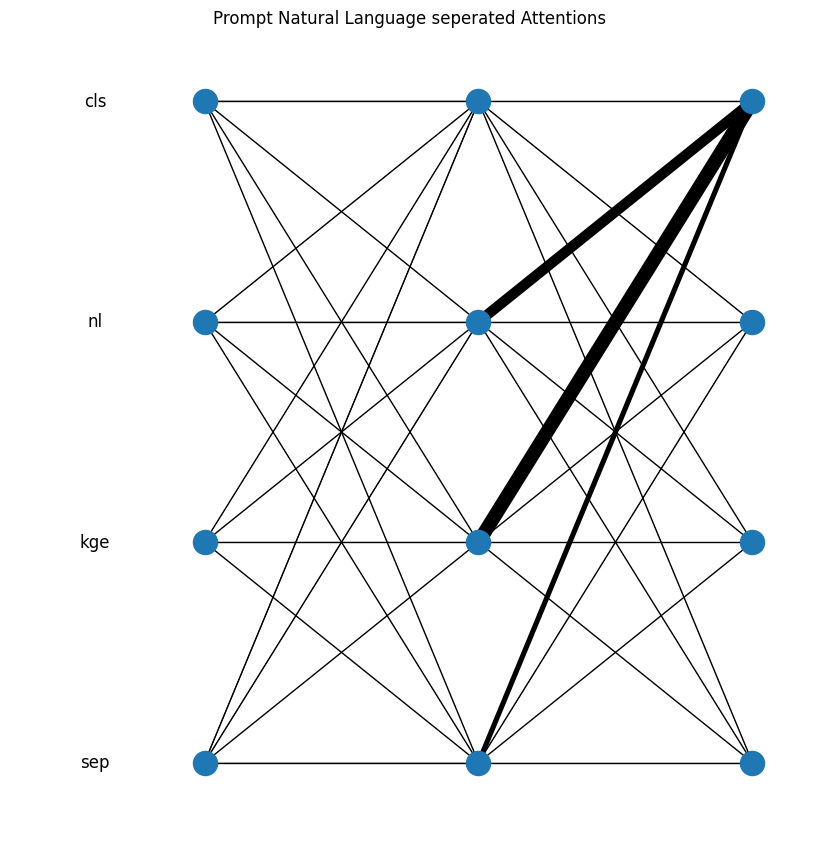

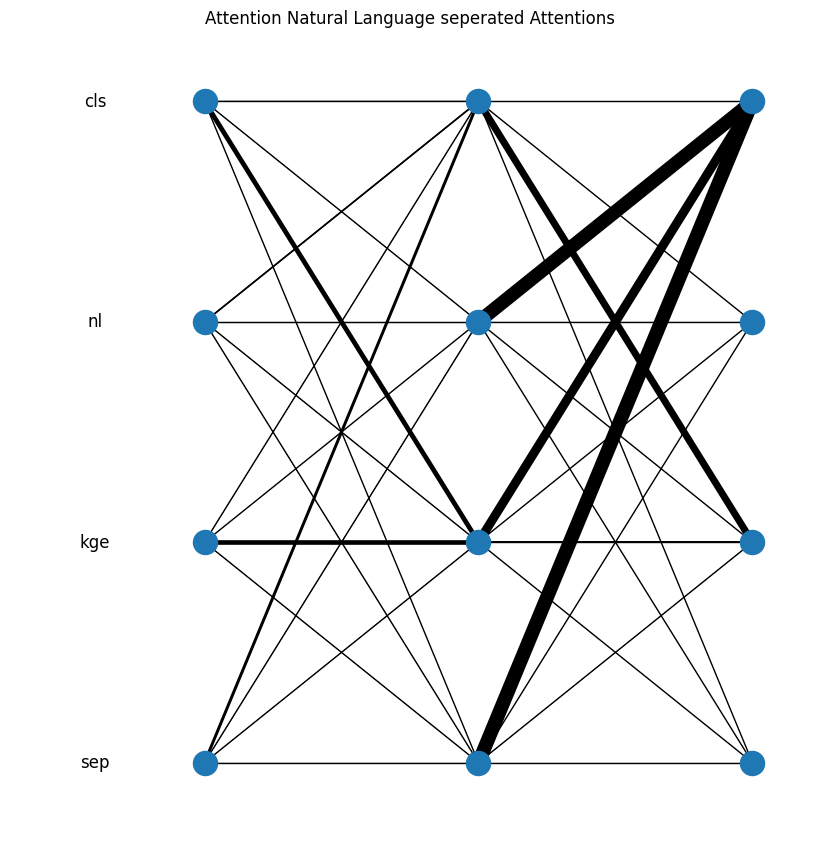

In [10]:
exp.plot_attention_graph(
    attentions=torch.from_numpy(vanilla_attentions_nl_seperated),
    token_labels=["cls", "nl", "sep"],
    title="Vanilla Natural Language seperated Attentions",
    weight_coef=10,
    save_path="./images/nl_seperated_vanilla_attentions.png",
)
exp.plot_attention_graph(
    attentions=torch.from_numpy(prompt_attentions_nl_seperated),
    token_labels=["cls", "nl", "kge", "sep"],
    title="Prompt Natural Language seperated Attentions",
    weight_coef=10,
    save_path="./images/nl_seperated_prompt_attentions.png",
)
exp.plot_attention_graph(
    attentions=torch.from_numpy(attention_attentions_nl_seperated),
    token_labels=["cls", "nl", "kge", "sep"],
    title="Attention Natural Language seperated Attentions",
    weight_coef=10,
    save_path="./images/nl_seperated_attention_attentions.png",
)